In [21]:
import torch


def meshgrid(size, o_x=0., o_y=0.):
    r = 1.
    a = torch.linspace(o_x-r, o_x+r, size)
    b = torch.linspace(o_y-r, o_y+r, size)
    x_t = a.repeat(size)
    y_t = b.repeat(size, 1).t().contiguous().view(-1)
    return (torch.stack([x_t, y_t], 1))

size = 256
xy = meshgrid(size)

xy.shape

torch.Size([65536, 2])

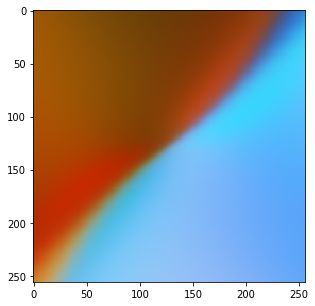

In [27]:
def get_W(in_units, out_units):
    if CUDA:
        w = torch.FloatTensor(out_units, in_units).uniform_()
    else:
        w = torch.cuda.FloatTensor(out_units, in_units).uniform_()
    w = (w - 0.5) * 2
    return w

def get_ws(widths):
    ws = []
    for w0, w1 in zip(widths[:-1], widths[1:]):
        ws.append(get_W(w0, w1))
    return ws

def forward(xy, ws):
    ret = xy
    for w in ws:
        ret = torch.matmul(ret, w.t())
        ret = torch.tanh(ret)
    ret = torch.sigmoid(ret)
    ret = (ret - ret.min()) / (ret.max() - ret.min())
    return ret.view(size, size, 3).cpu().numpy()

widths = [2, 8, 8, 64, 8, 8, 3]
ws1 = get_ws(widths)
out = forward(xy, ws1)

plt.figure(figsize=[5]*2)
plt.imshow(out)
plt.show()

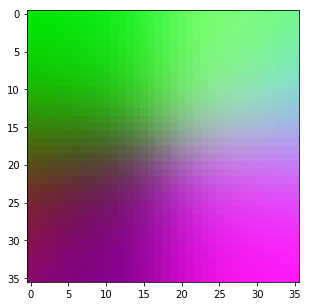

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import time

CUDA = True

def interp_ws(ws1, ws2, alpha):
    if CUDA:
        alpha = torch.cuda.FloatTensor([alpha])
    else:
        alpha = torch.FloatTensor([alpha])
    out = []
    for w1, w2 in zip(ws1, ws2):
        out.append(alpha * w1 + (1 - alpha) * w2)
    return out

def get_W(in_units, out_units):
    if CUDA:
        w = torch.FloatTensor(out_units, in_units).uniform_()
    else:
        w = torch.cuda.FloatTensor(out_units, in_units).uniform_()
    w = (w - 0.5) * 2
    return w

def get_ws(widths):
    ws = []
    for w0, w1 in zip(widths[:-1], widths[1:]):
        ws.append(get_W(w0, w1))
    return ws

def meshgrid(size, o_x=0., o_y=0.):
    r = 3.0**0.9
    a = torch.linspace(o_x-r, o_x+r, size)
    b = torch.linspace(o_y-r, o_y+r, size)
    x_t = a.repeat(size)
    y_t = b.repeat(size, 1).t().contiguous().view(-1)
    return (torch.stack([x_t, y_t], 1))

def forward(xy, ws):
    ret = xy
    for w in ws:
        ret = torch.matmul(ret, w.t())
        ret = torch.tanh(ret)
    ret = torch.sigmoid(ret)
    ret = (ret - ret.min()) / (ret.max() - ret.min())
    return ret.view(size, size, 3).cpu().numpy()

size = 36
widths = [2, 8, 8, 3]

xy = meshgrid(size)
if CUDA:
    xy = xy.cuda()
ws1 = get_ws(widths)
out = forward(xy, ws1)
plt.figure(figsize=[15]*2)
plt.imshow(out)
plt.show()

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #2 'mat2'

In [15]:
import os
from pydub import AudioSegment
from scipy.io.wavfile import read

def read_mp3(inname = '/home/liam/Music/(1994) Amber/04 Slip.mp3'):
    sound = AudioSegment.from_mp3(inname)
    sound.export("tmpaudio.wav", format="wav")
    a = read('tmpaudio.wav')
    os.remove('tmpaudio.wav')
    return a

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [16]:
sr, audio_orig = read_mp3()
audio_orig = audio_orig[sr*50:]
audio = (audio_orig.astype(np.float64).mean(1) / 32768.).astype(np.float32)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


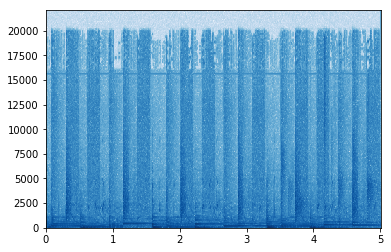

(311, 713)

In [17]:
import scipy.signal as signal
seconds = 5
audio_subset = audio[:sr*seconds]
f, t, Zxx = signal.stft(audio_subset, fs=sr, nperseg=620)
plt.pcolormesh(t, f, np.log10(np.abs(Zxx)), cmap='Blues')
plt.show()

Zxx.shape

In [18]:
audio_subset.shape

(220500,)

In [61]:
buffer = sr * 0.1 / 25
window = sr / 25.

In [72]:
num_batches = int((num_samples - buffer) / window)
st = 0
for i_batch in range(num_batches):
    en = st + window + buffer
    st_ = int(round(st))
    en_ = int(round(en))
    cut = audio_subset[st_:en_]
    st = st + window
    print (cut)

[0.00708008 0.00666809 0.00634766 ... 0.12547302 0.12574768 0.12748718]


In [63]:
buffer, window

(176.4, 1764.0)

In [35]:
spect.max(), spect.min()

(0.0, -80.0)

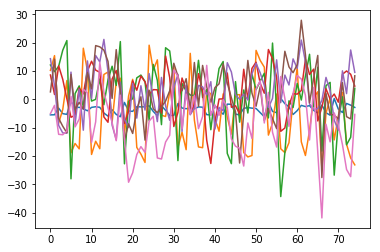

100%|██████████| 75/75 [00:01<00:00, 48.06it/s]


In [143]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt


frame_rate = 15
winstep=1./frame_rate
num_frames = frame_rate * seconds
batch_size = Zxx.shape[1] / float(num_frames)

mfcc_feat = mfcc(audio_subset, sr, winlen=winstep * 1.2, winstep=winstep, numcep=len(widths))

plt.plot(mfcc_feat)
plt.show()
mfcc_feat = ((mfcc_feat - mfcc_feat.mean()) / mfcc_feat.std())
mfcc_feat.shape


def module_ws(mfcc_feat, step, ws1):
    out = []
    for i, (m, w) in enumerate(zip(mfcc_feat[step], ws1)):
        out.append(ws1[i] * m)
    return out

ims = []
for i in tqdm(range(num_frames)):
    ws = module_ws(mfcc_feat, i, ws1)
    out = forward(xy, ws)
    ims.append(out)

In [101]:
from tqdm import tqdm

def get_ws_from_vec(widths, sliced_ws, w_bg, frame_index, num_frames):
    ws = []
    len_spect = sliced_ws[0].shape[1]
    window_size = int(2.0 * len_spect / float(num_frames))
    st = int(round(frame_index * float(len_spect) / float(num_frames)))
    en = st + window_size
    for i, (w0, w1) in enumerate(zip(widths[:-1], widths[1:])):
        w = (torch.FloatTensor(sliced_ws[i][:, st:en].mean(1)).cuda().view(w1, w0)) * .2# + w_bg[i] * 0.5
        ws.append(w)
    return ws

def slice_ws(logz, widths):
    ws = {}
    st = 0
    for i, (w0, w1) in enumerate(zip(widths[:-1], widths[1:])):
        if i not in ws:
            ws[i] = []
        en = st + w0 * w1
        ws[i].append(logz[st:en])
        st = en
    for i, (w0, w1) in enumerate(zip(widths[:-1], widths[1:])):
        ws[i] = np.array(ws[i][0])
        ws[i] = (ws[i] - ws[i].mean()) / ws[i].std()
        #ws[i] = (ws[i] - np.percentile(ws[i], 10)) / (np.percentile(ws[i], 90) -np.percentile(ws[i], 10))
    return ws

frame_rate = 25
num_frames = frame_rate * seconds
#logz = (np.abs(Zxx.real))
logz = spect
batch_size = logz.shape[1] / float(num_frames)
logz = (logz - logz.mean()) / logz.std()

print (logz.shape)
#logz = logz[:311][::-1]
print (logz.shape)

sliced_ws = slice_ws(logz, widths)

ws1 = get_ws(widths)
ws2 = get_ws(widths)

ims = []
st = 0
for alpha, i in tqdm(zip(np.linspace(0, 1, num_frames), range(num_frames))):
    en = st + batch_size * 1.2
    st_ = int(round(st))
    en_ = int(round(en))

    w_bg = interp_ws(ws1, ws2, alpha)
    
    ws = get_ws_from_vec(widths, sliced_ws, w_bg, i, num_frames)
    out = forward(xy, ws)
    ims.append(out)
    st = st + batch_size

2it [00:00, 12.30it/s]

(296, 431)
(296, 431)


125it [00:08, 14.55it/s]


(20, 431)


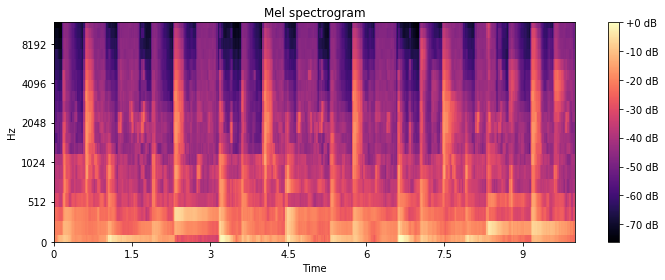

In [107]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

D = np.abs(librosa.stft(audio_subset))**2
#S = librosa.feature.melspectrogram(S=D)
S = librosa.feature.melspectrogram(y=audio_subset, sr=sr, n_mels=20, fmax=12000)

plt.figure(figsize=(10, 4))
spect = librosa.power_to_db(S, ref=np.max)
print (spect.shape)
librosa.display.specshow(spect,
                         y_axis='mel', fmax=12000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [112]:
widths = [spect.shape[0] + 2] + [24, 12, 8, 8, 8, 8, 3]
ws = get_ws(widths)

In [132]:
spect_t = torch.FloatTensor((spect - spect.mean()) / spect.std()).cuda()
st = 0
en = 20

def get_im(st, en, spect_t):
    spect_rep = spect_t[:, st:en].t().mean(0, keepdim=True).repeat([xy.shape[0], 1])
    return forward(torch.cat([xy, spect_rep], 1), ws)

frame_rate = 25
num_frames = frame_rate * seconds
step_size = spect_t.shape[1] / float(num_frames)
window_ratio = 1.5
window_size = int(step_size * window_ratio)

ims = []
st = 0
for i_frame in tqdm(range(num_frames)):
    en = st + window_size
    im = get_im(st, en, spect_t)
    ims.append(im)
    st = int(round(st + step_size))

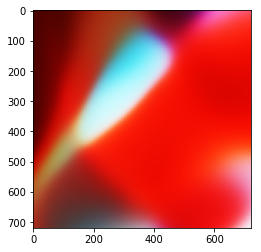

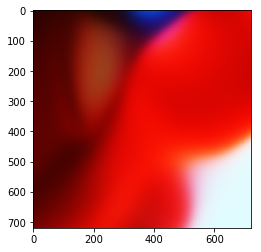

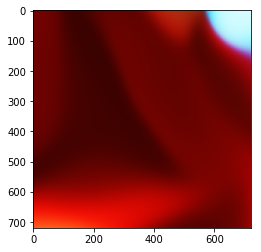

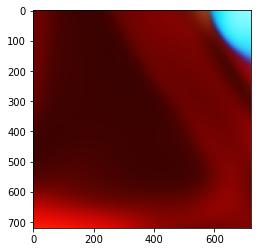

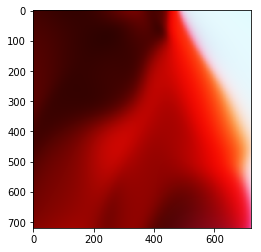

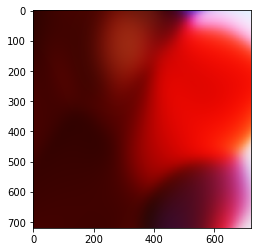

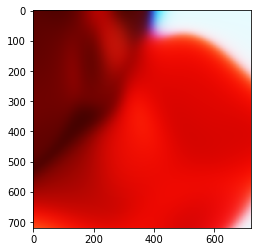

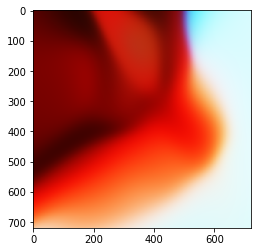

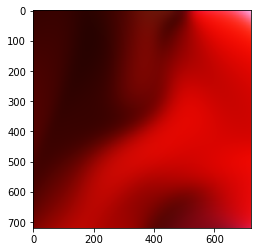

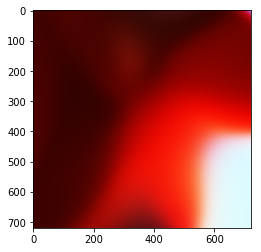

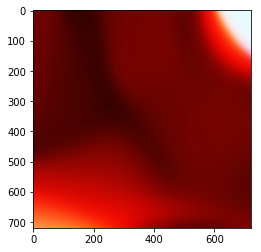

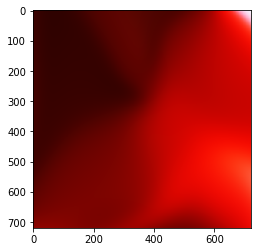

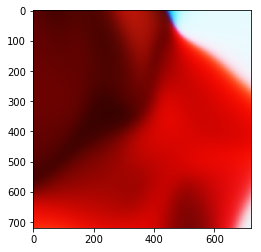

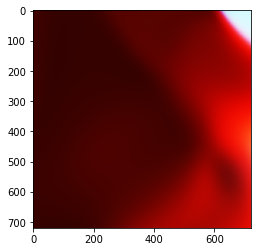

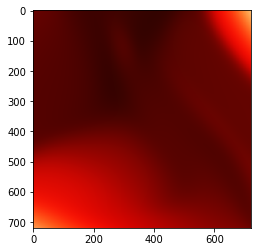

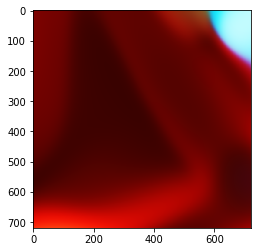

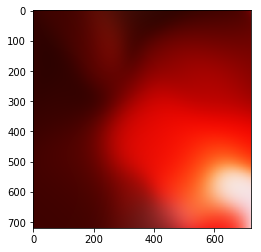

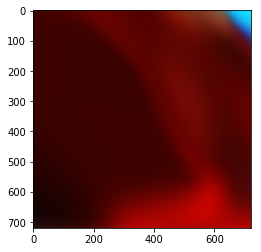

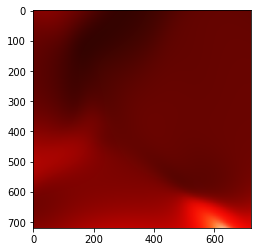

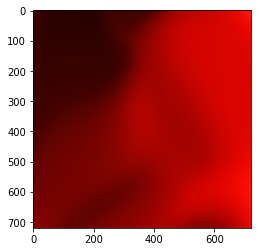

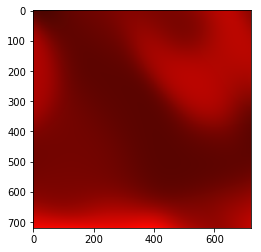

In [133]:
for im in ims[::len(ims)//20]:
    plt.imshow(im)
    plt.show()

In [134]:
from scipy.io.wavfile import write
write('tmp.wav', sr, audio_orig)

In [135]:
num_weights = sum([w0 * w1 for i, (w0, w1) in enumerate(zip(widths[:-1], widths[1:]))])

In [136]:
import os
import shutil
from skimage.color import hsv2rgb
hsv2rgb = lambda x: x
shutil.rmtree('cool2')
os.makedirs('cool2')
for i, im in tqdm(enumerate(ims)):
    plt.imsave('cool2/im%06d.png' % (i + 1), hsv2rgb(im))

125it [00:12, 10.30it/s]


In [79]:
reshape = int(len(cut) / float(num_weights))

6

In [75]:
ws1 = get_ws(widths)
ws2 = get_ws(widths)

ims = []
num_frames = 200

now = time.time()
for alpha, o_x, o_y in zip(np.linspace(0, 1, num_frames),
                           np.linspace(-1, 1, num_frames),
                           np.linspace(-1, 1, num_frames)):
    ws_this = interp_ws(ws1, ws2, alpha)
    xy = meshgrid(size, o_x, o_y)
    out = forward(xy, ws_this)
    ims.append(out)
    
print (time.time() - now)

4.694384574890137


In [3]:
cmd = 'ffmpeg -r 25 -f image2 -i cool/im%06d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p -vframes 1600 cool/test2.mp4'

from subprocess import Popen, PIPE

process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()


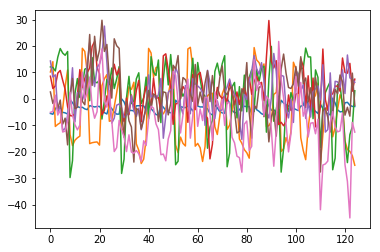

(125, 7)